# Bike model 2011-12

## 1) Define business goal / question of interest / research question

- Predict the amount of bike rentals at a specific time




In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import datetime, time
#import imageio


from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import PolynomialFeatures, StandardScaler, \
                                MinMaxScaler, FunctionTransformer,\
                                KBinsDiscretizer, OneHotEncoder

from sklearn.model_selection import cross_val_score, train_test_split , cross_validate

from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

pd.set_option('mode.chained_assignment', None)

## 2) Get data

In [2]:
df = pd.read_csv('train.csv', index_col = 0, parse_dates=True)
df.head()
#df.drop(df.loc[df['weather']==4].index, inplace=True)


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# Define Variable of interest
y = df['count']
X = df.drop(['count', 'casual', 'registered'], axis=1)

In [4]:
y.shape, X.shape

((10886,), (10886, 8))

In [5]:
X.isna().any() 

season        False
holiday       False
workingday    False
weather       False
temp          False
atemp         False
humidity      False
windspeed     False
dtype: bool

In [6]:
y.isna().any()

False

## 3) Train-test-split

In [7]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [8]:
Xtrain.shape, Xtest.shape

((8164, 8), (2722, 8))

## 4) EDA

In [ ]:
# Plot variables against each other
df_eda = Xtrain.join(ytrain)

In [ ]:

sns.pairplot(df_eda)

In [ ]:
df_eda.info()

In [ ]:
#plot of mean counts of df grouped by months
df_eda.groupby(pd.Grouper(freq='M'))['count'].mean().plot()
df_eda.groupby(pd.Grouper(freq='M'))['atemp'].max().plot()
# demand overall seems to be increasing 

s4 = pd.DataFrame(df_eda.groupby([lambda x: x.month])['count'].mean())
s4.plot()
#Demand for bikes is higher for the summer and there was an overall increase in demand between 2011 and 2012


In [ ]:
plt.figure(figsize=(12,6))
sns.heatmap(df_eda.corr(), annot=True)


In [ ]:
df_eda=df_eda.sort_index()
df_eda.head()


In [ ]:
rolling_count_eda=df_eda.rolling('28D')['count'].mean()
plt.plot(df_eda.index,rolling_count_eda)

In [ ]:
rolling_difference_eda = df_eda.diff()['count']
rolling_window_eda

## 5) Feature Engineering

In [9]:
def extract_dt_info(df):
    """extracts hour, weekday and month markers from dataframe with datetime index
    Parameters:
    -----------
    df: dataframe with datetime index
    """
    
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['weekday'] = df.index.weekday
    df['year'] = df.index.year
    
    return df

In [10]:
def w_w_interact(df):
    """makes returns 0 for workday and the weekday for a non-working day
    Parameters:
    -----------
    df: dataframe with columns 'workingday' and 'weekday'
    """
    #df = df.copy()
    df['nonworkingday_weekday'] = (df['workingday']-1)*df['weekday']*(-1)
    return df

In [11]:
Xtrain.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed'],
      dtype='object')

In [12]:
dummy_features = ['hour','month', 'weather', 'year']

interaction_features = ['temp', 'humidity', 'nonworkingday_weekday', 'windspeed']

#column_scaler = ColumnTransformer(transformers=[
#                      ('scaler', StandardScaler(), num_features)])

column_transformer = ColumnTransformer(transformers=[
       ('dummy', OneHotEncoder(handle_unknown = 'ignore'), dummy_features),    
      ('interaction_polynomial', PolynomialFeatures(interaction_only=False, degree=4), interaction_features)
                        #('drop', 'drop', drop_features)
    
])

In [13]:
transformer_pipeline = Pipeline(steps=[
                        ('extract_times', FunctionTransformer(extract_dt_info)),
                       ('make_ww_col', FunctionTransformer(w_w_interact)),                   
                        ('column_transformer', column_transformer)
])

In [14]:
linear_regression = Pipeline(steps=[
                        ('transformer', transformer_pipeline),
                        ('regression', LinearRegression())
                        
])

In [15]:
linear_regression.fit(Xtrain, ytrain)

Pipeline(memory=None,
         steps=[('transformer',
                 Pipeline(memory=None,
                          steps=[('extract_times',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<function extract_dt_info at 0x104108680>,
                                                      inv_kw_args=None,
                                                      inverse_func=None,
                                                      kw_args=None,
                                                      validate=False)),
                                 ('make_ww_col',
                                  FunctionTransformer(accept_sparse=False,
                                                      check_inverse=True,
                                                      func=<function w_w_in...
                                           

In [37]:
linear_regression.score(Xtrain, ytrain)

0.7265174643232148

In [20]:
cv_results = cross_validate(linear_regression, Xtrain, ytrain, n_jobs=-1, verbose=10)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.9s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


In [21]:
cv_results

{'fit_time': array([0.50458407, 0.46866703, 0.22809196, 0.23807907, 0.13769794]),
 'score_time': array([0.03487182, 0.05727911, 0.03959394, 0.02690601, 0.02169204]),
 'test_score': array([0.70453912, 0.71508678, 0.72525594, 0.72994646, 0.71387872])}

In [22]:
linear_regression.score(Xtest, ytest)

0.728809004126107

In [23]:
ridge_reg = Pipeline(steps=[
                        ('transformer', transformer_pipeline),
                        ('regression', Ridge(alpha=10)),
                        
])

In [24]:
ridge_reg.fit(Xtrain,ytrain)
ridge_reg.score(Xtrain, ytrain)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.51521e-18): result may not be accurate.
  overwrite_a=True).T


0.7257180563401127

In [28]:
num_features = ['temp', 'humidity', 'windspeed']
Xtrain_num=Xtrain[num_features]

scaler  = StandardScaler()

Xtrain_nums=scaler.fit_transform(Xtrain_num)
                
Xtrain_num


,temp,humidity,windspeed
datetime,,,
2012-10-06 06:00:00,22.14,88,16.9979
2011-09-04 08:00:00,27.06,78,11.0014
2011-10-17 01:00:00,22.96,54,26.0027
2011-05-16 14:00:00,27.88,51,0.0000
2011-11-01 22:00:00,14.76,81,0.0000
...,...,...,...
2012-09-10 01:00:00,22.14,60,12.9980
2011-07-14 14:00:00,30.34,35,19.0012
2011-01-15 10:00:00,7.38,59,11.0014


In [38]:
pca = PCA(n_components = 2) #how many components to return afrer the transformation, default is all
Xtrain_pca = pca.fit_transform(Xtrain_num)

In [39]:
Xtrain_pca.shape

(8164, 2)

In [40]:
pca.explained_variance_ratio_

array([0.75890139, 0.12640901])

([<matplotlib.axis.XTick at 0x102a0c710>,
 [Text(0, 0, '1'), Text(1, 0, '2'), Text(2, 0, '3'), Text(3, 0, '4')])

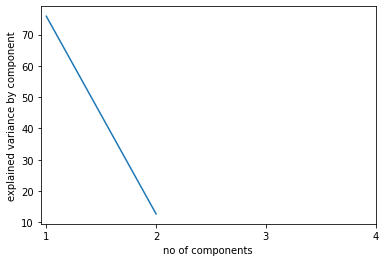

In [41]:
plt.plot(pca.explained_variance_ratio_*100)
plt.xlabel('no of components')
plt.ylabel('explained variance by component')
plt.xticks(np.arange(4), np.arange(1,5))

#PCA1 is at x=0 

(0.0, 100.0)

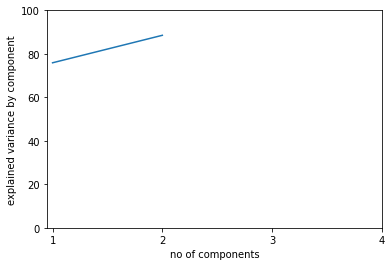

In [42]:
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('no of components')
plt.ylabel('explained variance by component')
plt.xticks(np.arange(4), np.arange(1,5))
plt.ylim(0,100)

In [43]:
def biplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = 'b', alpha = 0.5)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'k', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'k', ha = 'center', va = 'center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()

Text(0.5, 1.0, 'Biplot of PCA with Xtrain Data')

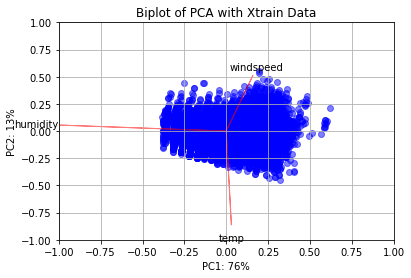

In [44]:
#Call the function with the first two PC
biplot(Xtrain_pca[:,0:2],np.transpose(pca.components_[0:2, :]), labels = Xtrain_num.columns)
plt.xlabel("PC1: "+f'{pca.explained_variance_ratio_[0]*100:.0f}'+"%")
plt.ylabel("PC2: "+f'{pca.explained_variance_ratio_[1]*100:.0f}'+"%")
plt.title("Biplot of PCA with Xtrain Data")